In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [10]:
from skimage import io, filters, draw
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.morphology import disk
from skimage.filters import median
import os
import pvlib
import pandas as pd
from pysolar import solar
from pytz import timezone
import datetime
from pytz import timezone
from pytz import common_timezones
import pytz
from PIL import Image
import sys
import time as t
from numpy import asarray
import scipy
import csv
from keras.models import Sequential
from keras.layers import Dense

#For Sun detection
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
import cv2

folder_image = "Sky_Camera_Images"
folder_cropped = 'Sky_Camera_Images_Cropped'
folder_sun = 'Sky_Camera_Images_Sun_Detection'
folder_dest = 'Sky_Camera_Ring_Destination'
folder_src = 'Sky_Camera_Ring_Source'

Using TensorFlow backend.


In [3]:
#Detects the sun and colors it in black so that it's not counted in the image
def sun_detect(filename, destination_path):
# load the image, convert it to grayscale, and blur it
    image = cv2.imread(os.getcwd() +'\\Sky_Camera_Images_Cropped\\' + filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    # threshold the image to reveal light regions in the
    # blurred image
    thresh = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY)[1]
    # perform a series of erosions and dilations to remove
    # any small blobs of noise from the thresholded image
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    # perform a connected component analysis on the thresholded
    # image, then initialize a mask to store only the "large"
    # components
    labels = measure.label(thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > 300:
            mask = cv2.add(mask, labelMask)
    # find the contours in the mask, then sort them from left to
    # right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    temp_size = len(cnts)
    if temp_size > 0:
        cnts = contours.sort_contours(cnts)[0]
        # loop over the contours
        cnts_size = len(cnts)
        iteration = 1
        for (i, c) in enumerate(cnts):
            # draw the bright spot on the image
            (x, y, w, h) = cv2.boundingRect(c)
            if iteration == 1:
                w_temp = w
                h_temp = h
                c_temp = c
                iteration = 2

            if((w > (0.8 * h)) or (h > (0.8 * w))):
                if(w > w_temp or h > h_temp):
                    w_temp = w
                    h_temp = h
                    c_temp = c

        # show the output image
        ((cX, cY), radius) = cv2.minEnclosingCircle(c_temp)
        print("Found spots: " + str(cnts_size))
        for i in range(0,5):
            obj = io.imread(os.getcwd() +'\\Sky_Camera_Images_Cropped\\' + filename)
            img = ring_divider(obj, int(cX), int(cY), 200 + 60*i, 60)
            plt.imsave(destination_path + str(i) + ".jpg", img)

directory = os.listdir(os.getcwd() +'\\' + folder_dest + '\\')
if len(directory) == 0:
    sun_detect("2019-04-17 13~20~00-07~00.jpg")

In [4]:
def ring_divider(sky, width, height, size, wind_speed):
    circle_radius = size
    # Trim the pixels around the sky
    sky_circle_1 = np.zeros((sky.shape[0], sky.shape[1]), dtype=np.uint8)
    rr, cc = draw.circle(height, width, circle_radius)
    sky_circle_1[rr, cc] = 1
    sky_trimmed = sky.copy()
    sky_trimmed[sky_circle_1 == 1] = 0
   
    sky_circle_2 = np.zeros((sky.shape[0], sky.shape[1]), dtype=np.uint8)
    rr, cc = draw.circle(height, width, circle_radius+wind_speed)
    sky_circle_2[rr,cc] = 1
    sky_trimmed[sky_circle_2 == 0] = 0
    return sky_trimmed

def find_next_file(filename):
    print("Before: " + filename)
    if filename[15] == "5":
        filename[15] == "0"
        if filename[14] == "5":
            filename[14] = "0"
        else:
            filename[14] = str(int(filename[14]) + 1)
    print("Next: " + filename)
    return filename

In [5]:
class Cloud_Stats:
    def __init__(self):
        self.red_standard_dev = None
        self.green_standard_dev = None
        self.blue_standard_dev = None
        self.red_median = None
        self.green_median = None
        self.blue_median = None
        self.red_mode = None
        self.green_mode = None
        self.blue_mode = None
        self.red_mean = None
        self.green_mean = None
        self.blue_mean = None
        self.image_path = None
        self.hazed_ratio = None
        self.obj = None
        self.obj_valid = None
        self.obj_train = None
        self.hazed_valid = None
        self.hazed_train = None
        self.total = 0
        self.total_cloud = 0
        self.total_sky = 0
        self.ratio_sky = 0
        self.train_temp_folder = "Train_Temp_Folder"
        self.valid_temp_folder = "Valid_Temp_Folder"
        
    def print_stats(self):
        print("red_standard_dev: " + str(self.red_standard_dev) + " green_standard_dev: " + str(self.green_standard_dev) + " blue_standard_dev: " + str(self.blue_standard_dev))
        print("red_median: " + str(self.red_median) + " green_median: " + str(self.green_median) + " blue_median: " + str(self.blue_median))
        print("red_mode: " + str(self.red_mode) + " green_mode: " + str(self.green_mode) + " blue_mode: " + str(self.blue_mode))
        print("red_mean: " + str(self.red_mean) + " green_mean: " + str(self.green_mean) + " blue_mean: " + str(self.blue_mean))
        print("Cloud ratio: " + str(self.ratio_sky) + " Sky_pixels: " + str(self.total_sky) + " Cloud_pixels: " + str(self.total_cloud) + " Total haze ratio: " + str(self.total))
    
    def calculate_stats(self,index, stat_type):
        temp = []
        for i, row in enumerate(self.hazed_ratio):
            for j, col in enumerate(row):
                if(col != 10):
                    temp.append(self.obj[i][j][index])
        if stat_type == 1:
                return np.std(temp)
        elif stat_type == 2:
                return np.median(temp)
        elif stat_type == 3:
                val = max(set(temp), key = temp.count)
                return val
        elif stat_type == 4:
                return np.mean(temp)
        else:
                return -10000
            
    def calculate_all_stats(self, image_path, filename):
        self.obj = io.imread(image_path + filename)
        self.hazed_ratio = Process_Image_Haze_Ratio(image_path + filename)
        self.red_standard_dev = round(self.calculate_stats(0, 1), 2)
        self.green_standard_dev = round(self.calculate_stats(1, 1), 2)
        self.blue_standard_dev = round(self.calculate_stats(2, 1), 2)
        self.red_median = int(self.calculate_stats(0, 2))
        self.green_median = int(self.calculate_stats(1, 2))
        self.blue_median = int(self.calculate_stats(2, 2))
        self.red_mode = round(self.calculate_stats(0, 3), 2)
        self.green_mode = round(self.calculate_stats(1, 3), 2)
        self.blue_mode = round(self.calculate_stats(2, 3), 2)
        self.red_mean = round(self.calculate_stats(0, 4), 2)
        self.green_mean = round(self.calculate_stats(1, 4), 2)
        self.blue_mean = round(self.calculate_stats(2, 4), 2)
        self.calculate_cloud_cover()
    
    def produce_training_data(self, image_path_train, image_path_validation, file_path):
        train_list = os.listdir(image_path_train)
        validation_list = os.listdir(image_path_validation)
        try:
            os.mkdir(self.train_temp_folder)
        except:
            print("Folder exists")
        try:
            os.mkdir(self.valid_temp_folder)
        except:
            print("Folder exists")
        for count, fname in enumerate(train_list):
            data_file = open(file_path + fname[:-4]+ ".csv", mode = 'w+')
            sun_detect(fname, os.getcwd() + "\\" + self.train_temp_folder + "\\")
            sun_detect(validation_list[count], os.getcwd() + "\\" + self.valid_temp_folder + "\\")
            train_temp_list = os.listdir(self.train_temp_folder)
            valid_temp_list = os.listdir(self.valid_temp_folder)
            print("On file " + str(count) + "/" + str(len(train_list)))
            for file_num, temp_file in enumerate(train_temp_list):
                print("Processing ring: " + temp_file)
                self.calculate_all_stats(self.train_temp_folder + "\\", temp_file)
                data = ""
                data += str(round(self.red_standard_dev/127, 2)) + ", "
                data += str(round(self.green_standard_dev/127, 2)) + ", "
                data += str(round(self.blue_standard_dev/127, 2)) + ", "
                data += str(round(self.red_median/255, 2)) + ", "
                data += str(round(self.green_median/255, 2)) + ", "
                data += str(round(self.blue_median/255, 2)) + ", "
                data += str(round(self.red_mean/255, 2)) + ", "
                data += str(round(self.green_mean/255, 2)) + ", "
                data += str(round(self.blue_mean/255, 2)) + ", "
                data += str(self.ratio_sky) + ", "
                print(self.valid_temp_folder + "\\" + valid_temp_list[file_num])
                self.hazed_ratio = Process_Image_Haze_Ratio(self.valid_temp_folder + "\\" + valid_temp_list[file_num])
                self.calculate_cloud_cover()
                data += str(self.ratio_sky) +"\n"
                data_file.write(data)
            data_file.close()
        
    def save_to_file_ring(self, path, filename):
        file_data = []
        data_file = open(path + filename + '.csv', mode='w+')
        next_fname = find_next_file(filename +".jpg")
        sun_detect(next_fname, os.getcwd() + "\\Sky_Camera_Ring_Dest\\")
        print("Processing data for this file: " + filename + " and the next file: " + next_fname)
        for count, fname in enumerate(os.listdir(self.image_path)):
            print("Processing this ring" + fname)
            self.obj = io.imread(self.image_path + fname)
            self.hazed_ratio = Process_Image_Haze_Ratio(self.image_path + fname)
            self.calculate_all_stats()
            data = ""
            data += str(round(self.red_standard_dev/127, 2)) + ", "
            data += str(round(self.green_standard_dev/127, 2)) + ", "
            data += str(round(self.blue_standard_dev/127, 2)) + ", "
            data += str(round(self.red_median/255, 2)) + ", "
            data += str(round(self.green_median/255, 2)) + ", "
            data += str(round(self.blue_median/255, 2)) + ", "
            data += str(round(self.red_mean/255, 2)) + ", "
            data += str(round(self.green_mean/255, 2)) + ", "
            data += str(round(self.blue_mean/255, 2)) + ", "
            data += str(self.ratio_sky) + ", "
            self.hazed_ratio = Process_Image_Haze_Ratio(os.getcwd() + "\\Sky_Camera_Ring_Dest\\" + next_fname)
            self.calculate_cloud_cover()
            data += str(self.ratio_sky) +"\n"
            data_file.write(data)
        data_file.close()
        return 0
    def save_to_file_result(self, path, filename):
        data_file = open(path + filename + '.csv', mode='w+')
        for fname in os.listdir(self.image_path):
            print(self.image_path + fname)
            self.obj = io.imread(self.image_path + fname)
            self.hazed_ratio = Process_Image_Haze_Ratio(self.image_path + fname)
            self.calculate_cloud_cover()
            data = str(self.ratio_sky) + "\n"
            self.print_stats()
            data_file.write(data)
        data_file.close()
        return 0
    
    def calculate_cloud_cover(self):
        self.total = 0
        self.total_sky = 0
        self.total_cloud = 0
        for row in self.hazed_ratio:
            for col in row:
                if col != 10:
                    self.total += col
                    if col > 0:
                        self.total_sky += 1
                    else:
                        self.total_cloud += 1
        self.ratio_sky = round(self.total_cloud/(self.total_sky + self.total_cloud), 2)
        

In [6]:
def Trim_Outer_Circle(sky):
    # Trim out the extra black on the left and right side of the image
    x1_trim = 300
    x2_trim = 2280
    
    # Determine the dimensions of the image
    width = sky.shape[0]
    height = sky.shape[1]
    center_on_width = int(width / 2)
    center_on_height = int(height / 2)
    width, height, center_on_width, center_on_height
    circle_radius = 971
    
    # Trim the pixels around the sky
    sky_circle = np.zeros((width, height), dtype=np.uint8)
    rr, cc = draw.circle(center_on_width, center_on_height, circle_radius)
    sky_circle[rr, cc] = 1
    sky_trimmed = sky.copy()
    sky_trimmed[sky_circle == 0] = 0
    return sky_trimmed[:, x1_trim : x2_trim]
    
def Load_And_Trim(filename):
    sky = io.imread(filename)
    sky_trimmed = Trim_Outer_Circle(sky)
    return sky_trimmed


In [7]:
def calculate_ratio(red, green, blue):
    r = int(red)
    g = int(green)
    b = int(blue)
    numerator = (float(r+b)/2) - float(g)
    denominator = (float((r+b))/2) + float(g)
    if denominator == 0:
        return 10
    else:
        return numerator/denominator 
def Process_Image_Haze_Ratio_Plt(image_path):
    arr = []
    sky_trimmed = io.imread(image_path)
    sky_circle = np.zeros((sky_trimmed.shape[0], sky_trimmed.shape[1]), dtype=np.uint8)
    for i, row in enumerate(sky_trimmed):
        for j, col in enumerate(row):
            ratio = calculate_ratio(col[0],col[1],col[2])
            sky_circle[i][j] = ratio
            if ratio != 10:
                arr.append(ratio)
    return sky_circle
    
def Process_Image_Haze_Ratio(image_path):
    sky_trimmed = cv2.imread(image_path)
    rows, cols, channels = sky_trimmed.shape
    arr = []
    bla = np.zeros((rows, cols), dtype=np.float64)
    total = []
    for i in range(rows):
        for j in range(cols):
            ratio = calculate_ratio(sky_trimmed[i,j,0], sky_trimmed[i,j,1], sky_trimmed[i,j,2])
            bla[i,j] = ratio
            total.append(ratio)
            if ratio != 10:
                arr.append(ratio)
    return bla

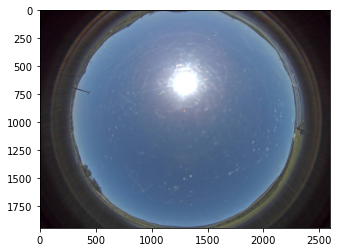

In [8]:
file_name =  '2019-04-17 13~20~00-07~00'
image_path = os.getcwd() +'\\'+ folder_image +'\\' + file_name + '.jpg'
obj = io.imread(image_path)
plt.imshow(obj)
trimmed = Load_And_Trim(image_path)
#cropped_image_path = os.getcwd() +'\\Sky_Camera_Images\\' + file_name + ' cropped ' + '.jpg'
#plt.imsave(cropped_image_path, trimmed)

In [9]:
#Fill folder with cropped images from original
directory = os.listdir(os.getcwd() +'\\' + folder_cropped + '\\')
if len(directory) == 0:
    for filename in os.listdir(os.getcwd() +'\\' + folder_image + '\\'):
        trimmed = Load_And_Trim(os.getcwd() +'\\' + Sky_Camera_Ring_Destination + "\\" + filename)
        cropped_image_path = os.getcwd() +'\\' + folder_cropped + '\\' + filename
        plt.imsave(cropped_image_path, trimmed)

In [10]:
#Example of image with Haze filter applied
hazed_ratio = Process_Image_Haze_Ratio(image_path)

C:\Users\mihir\Documents\University\4.Senior_Year\2.Winter Quarter\CPE461\Cloud-Prediction\Sky_Camera_Images_Cropped\2019-04-16 13~25~00-07~00.jpg
red_standard_dev: 33.37 green_standard_dev: 30.45 blue_standard_dev: 26.85
red_median: 119 green_median: 120 blue_median: 121
red_mode: 128 green_mode: 128 blue_mode: 127
red_mean: 116.93 green_mean: 118.37 blue_mean: 122.23
Cloud ratio: 0.49 Sky_pixels: 1536669 Cloud_pixels: 1452767 Total haze ratio: 28160.45871901315


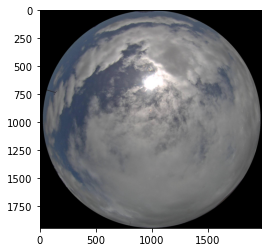

In [11]:
# Apply a median filter to image with haze filter
filename = '2019-04-16 13~25~00-07~00.jpg'
folder = 'Sky_Camera_Images_Cropped'
obj = io.imread(os.getcwd() + '\\' + folder + '\\' + filename)
print(os.getcwd() + '\\' + folder + '\\' + filename)

all_stats = Cloud_Stats()
all_stats.calculate_all_stats(os.getcwd() + '\\' + folder + '\\', filename)
all_stats.print_stats()
plt.imshow(obj)


2019-04-17 13~20~00-07~00.jpg
red_standard_dev: 33.23 green_standard_dev: 30.34 blue_standard_dev: 28.8
red_median: 90 green_median: 118 blue_median: 155
red_mode: 72 green_mode: 101 blue_mode: 141
red_mean: 96.87 green_mean: 121.25 blue_mean: 155.9
Cloud ratio: 0.07 Sky_pixels: 2802812 Cloud_pixels: 202522 Total haze ratio: 82160.90696656935


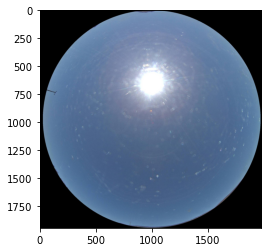

In [12]:
filename = '2019-04-17 13~20~00-07~00.jpg'
print(filename)
obj = io.imread(os.getcwd() + '\\' + folder + '\\' + filename)
all_stats = Cloud_Stats()
all_stats.calculate_all_stats(os.getcwd() + '\\' + folder + '\\', filename)
all_stats.print_stats()
plt.imshow(obj)

In [13]:
#Zenith Calculation
#Found from google maps
gold_tree_longitude = 120.6908325
gold_tree_latitude = 35.3195311
time =  pd.DatetimeIndex(['2020-05-06 12:55:00'], freq=None, tz = datetime.timezone.utc) - pd.Timedelta(hours = 7)
sun_data = pvlib.solarposition.ephemeris(time, gold_tree_latitude, gold_tree_longitude, pressure=101325, temperature=12)
print(sun_data.zenith)
print(sun_data.elevation)
print(sun_data.azimuth)

2020-05-06 05:55:00+00:00    32.77275
Name: zenith, dtype: float64
2020-05-06 05:55:00+00:00    57.22725
Name: elevation, dtype: float64
2020-05-06 05:55:00+00:00    243.196334
Name: azimuth, dtype: float64


In [14]:
dobj = datetime.datetime.now(pytz.utc) - datetime.timedelta(hours=7)

dobj2 = datetime.datetime(2019,5,14,13,22,0,0, tzinfo=datetime.timezone.utc) #+ datetime.timedelta(hours=7)
print(dobj)
print(dobj2)
sun = solar.get_azimuth(gold_tree_latitude, gold_tree_longitude, dobj2)
print('bearing', sun)
if abs(sun) >= 180:
    sundirection = abs(sun) - 180
else:
    sundirection = abs(sun) + 180

print('bearing', sundirection)

2020-06-11 14:14:56.443193+00:00
2019-05-14 13:22:00+00:00
bearing 319.98517965955807
bearing 139.98517965955807


In [15]:
#Find the sun
directory = os.listdir(os.getcwd() +'\\' + folder_sun + '\\')
if len(directory) == 0:
    for filename in os.listdir(os.getcwd() +'\\Sky_Camera_Images_Cropped\\'):
        # load the image, convert it to grayscale, and blur it
        image = cv2.imread(os.getcwd() +'\\Sky_Camera_Images_Cropped\\' + filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (11, 11), 0)
        # threshold the image to reveal light regions in the
        # blurred image
        thresh = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY)[1]
        # perform a series of erosions and dilations to remove
        # any small blobs of noise from the thresholded image
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=4)
        # perform a connected component analysis on the thresholded
        # image, then initialize a mask to store only the "large"
        # components
        labels = measure.label(thresh, neighbors=8, background=0)
        mask = np.zeros(thresh.shape, dtype="uint8")
        # loop over the unique components
        for label in np.unique(labels):
            # if this is the background label, ignore it
            if label == 0:
                continue
            # otherwise, construct the label mask and count the
            # number of pixels 
            labelMask = np.zeros(thresh.shape, dtype="uint8")
            labelMask[labels == label] = 255
            numPixels = cv2.countNonZero(labelMask)
            # if the number of pixels in the component is sufficiently
            # large, then add it to our mask of "large blobs"
            if numPixels > 300:
                mask = cv2.add(mask, labelMask)
        # find the contours in the mask, then sort them from left to
        # right
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        temp_size = len(cnts)
        if temp_size > 0:
            cnts = contours.sort_contours(cnts)[0]
            # loop over the contours
            cnts_size = len(cnts)
            print(cnts_size)
            iteration = 1
            for (i, c) in enumerate(cnts):
                # draw the bright spot on the image
                (x, y, w, h) = cv2.boundingRect(c)
                if iteration == 1:
                    w_temp = w
                    h_temp = h
                    c_temp = c
                    iteration = 2

                if((w > (0.8 * h)) or (h > (0.8 * w))):
                    if(w > w_temp or h > h_temp):
                        print("Width:" + str(w) + " Height: " + str(h))
                        w_temp = w
                        h_temp = h
                        c_temp = c

            # show the output image
            ((cX, cY), radius) = cv2.minEnclosingCircle(c_temp)
            cv2.circle(image, (int(cX), int(cY)), int(200),(0, 0, 0), -1)
            cv2.imwrite(os.getcwd() +'\\Sky_Camera_Images_Sun_Detection\\' + filename, image)

In [16]:
#Code to generate data in a .csv file for a given folder of sky images
for filename in os.listdir(os.getcwd() +'\\Sky_Camera_Ring_Validation\\'):
    all_stats = Cloud_Stats(os.getcwd() + '\\Sky_Camera_Ring_Destination\\', "1.jpg")
    try:
        all_stats.save_to_file_result(os.getcwd() + '\\Sky_Camera_Validation_Results\\', filename[:-4])
    except:
        continue

TypeError: __init__() takes 1 positional argument but 3 were given

In [9]:
all_stats = Cloud_Stats()
all_stats.produce_training_data(os.getcwd() + '\\Sky_Camera_Ring_Source\\', os.getcwd() + '\\Sky_Camera_Ring_Validation\\', os.getcwd() + '\\Sky_Camera_Data\\')


Folder exists
Folder exists


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\mihir\\Documents\\University\\4.Senior_Year\\2.Winter Quarter\\CPE461\\Cloud-Prediction\\Sky_Camera_Data\\2019-04-19 11~55~00-07~00.csv'

In [20]:
#Combine multiple files into one big input set
data_file = open(os.getcwd() +'\\Sky_Camera_Data\\' + "master_data"+ ".csv", mode = 'w+')
csv_list = os.listdir(os.getcwd() +'\\Sky_Camera_Data\\')
for i, filename in enumerate(csv_list) :
    if(filename != "master_data.csv") or (filename != "master_data_validation.csv"):
        file = open(os.getcwd() +'\\Sky_Camera_Data\\' + filename, "r")
        for line in file:
            data_file.write(line)
        file.close()
        print(str(i) + "/" + str(len(csv_list)))
data_file.close()
    

0/34
1/34
2/34
3/34
4/34
5/34
6/34
7/34
8/34
9/34
10/34
11/34
12/34
13/34
14/34
15/34
16/34
17/34
18/34
19/34
20/34
21/34
22/34
23/34
24/34
25/34
26/34
27/34
28/34
29/34
30/34
31/34
32/34


In [27]:
dataset = np.loadtxt(os.getcwd() + "\\Sky_Camera_Data\\" + "master_data.csv", delimiter=", ")
dataset_valid = np.loadtxt(os.getcwd() + "\\Sky_Camera_Data\\" + "master_data_validation.csv", delimiter=", ")
X = dataset[:,0:10]
Y = dataset[:,10]
X_Valid = dataset_valid[:,0:10]
Y_Valid = dataset_valid[:,10]
# 1. define the network
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(1))
# 2. compile the network
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
# 3. fit the network
history = model.fit(X, Y, epochs=100, batch_size=10)
# 4. evaluate the network
loss, accuracy = model.evaluate(X_Valid, Y_Valid)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
# 5. make predictions
probabilities = model.predict(X)
predictions = [float(round(x[0])) for x in probabilities]
accuracy = np.mean(predictions == Y)
print("Prediction Accuracy: %.2f%%" % (accuracy*100))

Epoch 1/100
165/165 [==============================] - 0s 840us/step - loss: 0.0688 - accuracy: 0.0000e+00
Epoch 2/100
165/165 [==============================] - 0s 115us/step - loss: 0.0378 - accuracy: 0.0000e+00
Epoch 3/100
165/165 [==============================] - 0s 145us/step - loss: 0.0363 - accuracy: 0.0000e+00
Epoch 4/100
165/165 [==============================] - 0s 145us/step - loss: 0.0352 - accuracy: 0.0000e+00
Epoch 5/100
165/165 [==============================] - 0s 139us/step - loss: 0.0343 - accuracy: 0.0000e+00
Epoch 6/100
165/165 [==============================] - 0s 121us/step - loss: 0.0338 - accuracy: 0.0000e+00
Epoch 7/100
165/165 [==============================] - 0s 139us/step - loss: 0.0335 - accuracy: 0.0000e+00
Epoch 8/100
165/165 [==============================] - 0s 157us/step - loss: 0.0330 - accuracy: 0.0000e+00
Epoch 9/100
165/165 [==============================] - 0s 139us/step - loss: 0.0327 - accuracy: 0.0000e+00
Epoch 10/100
165/165 [===============

Epoch 77/100
165/165 [==============================] - 0s 127us/step - loss: 0.0191 - accuracy: 0.0000e+00
Epoch 78/100
165/165 [==============================] - 0s 151us/step - loss: 0.0191 - accuracy: 0.0000e+00
Epoch 79/100
165/165 [==============================] - 0s 127us/step - loss: 0.0190 - accuracy: 0.0000e+00
Epoch 80/100
165/165 [==============================] - 0s 133us/step - loss: 0.0188 - accuracy: 0.0000e+00
Epoch 81/100
165/165 [==============================] - 0s 127us/step - loss: 0.0188 - accuracy: 0.0000e+00
Epoch 82/100
165/165 [==============================] - 0s 121us/step - loss: 0.0187 - accuracy: 0.0000e+00
Epoch 83/100
165/165 [==============================] - 0s 115us/step - loss: 0.0186 - accuracy: 0.0000e+00
Epoch 84/100
165/165 [==============================] - 0s 127us/step - loss: 0.0186 - accuracy: 0.0000e+00
Epoch 85/100
165/165 [==============================] - 0s 139us/step - loss: 0.0185 - accuracy: 0.0000e+00
Epoch 86/100
165/165 [======